In [1]:
import pretty_midi
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
import os
import random

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

def midi_filename_to_piano_roll(midi_filename):
    """Returns matrix which represents a piano roll of specified midi filename.
    Reads the midi file using pretty_midi, calls get_piano_roll() and binarizes
    notes (some notes that are being pressed have different volume -- we don't
    really need this information during training)
    
    Parameters
    ----------
    midi_filename : string
        Full-path of the midi file
        
    Returns
    -------
    piano_roll : numpy matrix of size 128xseq_length
        Matrix that cotains piano roll
    """

    midi_data = pretty_midi.PrettyMIDI(midi_filename)
    
    piano_roll = midi_data.get_piano_roll()
    
    # Binarize the pressed notes
    piano_roll[piano_roll > 0] = 1
    
    return piano_roll


def pad_piano_roll(piano_roll, max_length=132333, pad_value=0):
    """Pads piano roll to have a certain sequence length: max_length with
    a special value: pad_value
    
    Parameters
    ----------
    piano_roll : numpy matrix shape (128, seq_length) 
        Matrix representing the piano roll
        
    Returns
    -------
    piano_roll : numpy matrix shape (128, max_length)
        Matrix representing the padded piano roll
    """
    
    # We hardcode 128 -- because we will always use only
    # 128 pitches
    
    original_piano_roll_length = piano_roll.shape[1]
    
    padded_piano_roll = np.zeros((128, max_length))
    padded_piano_roll[:] = pad_value
    
    padded_piano_roll[:, :original_piano_roll_length] = piano_roll

    return padded_piano_roll


def piano_roll_random_crop(piano_roll, crop_length=10000):

    piano_roll_length = piano_roll.shape[1]

    max_possible_start_crop = piano_roll_length - crop_length 

    if max_possible_start_crop < 0:

        return piano_roll

    random_start_pos = random.randrange(max_possible_start_crop)

    piano_roll_crop = piano_roll[:, random_start_pos:random_start_pos+crop_length]

    return piano_roll_crop



class NotesGenerationDataset(data.Dataset):
    """Dataloader for note-level (like char-rnn) rnn training
    Dataloader reads midi files in the provided directory and forms
    batches which contain original sequence without the last element,
    original sequence without the first element (typical note/char-level model)
    and length of these sequences.
    """
    
    
    def __init__(self, midi_folder_path, longest_sequence_length=74569):
        """Initializes the note dataloader.

        Reads all the .midi files from the specified directory.
        Important: set longest_sequence_length to None if you are
        using this loader for a different midi dataset.
        
        When being used with torch.utils.data.DataLoader, returns
        batch with training sequence of the size (batch_size, longest_sequence_length, 128),
        corresponding ground truth (batch_size, longest_sequence_length, 128) and a tensor with
        actual (non-padded) length of each sequence in the batch.
        We pad each sequence to become of the size longest_sequence_length, which might seem
        to be an inefficient solution -- we later trim the batch using post_process_sequence_batch()
        helper function -- be sure to use it after you get batches using this dataloader.

        Parameters
        ----------
        midi_folder_path : string
            String specifying the path to the midi folder
        longest_sequence_length : int
            Constant specifying the longest midi sequence in the dataset
            Set it to None if you don't know it (it might take some time)
            to initilize then.
        """
        
        self.midi_folder_path = midi_folder_path
        
        midi_filenames = os.listdir(midi_folder_path)
                
        midi_full_filenames = map(lambda filename: os.path.join(midi_folder_path, filename),
                                  midi_filenames)
        
        self.midi_full_filenames = midi_full_filenames
        
        
        if longest_sequence_length is None:
            
            self.update_the_max_length()
            
        else:
            
            self.longest_sequence_length = longest_sequence_length
    
    
    def update_the_max_length(self):
        """Recomputes the longest sequence constant of the dataset.

        Reads all the midi files from the midi folder and finds the max
        length.
        """
        
        sequences_lengths = map(lambda filename: midi_filename_to_piano_roll(filename).shape[1],
                                self.midi_full_filenames)
        
        max_length = max(sequences_lengths)
        
        self.longest_sequence_length = max_length
        
    
    def __len__(self):
        
        return len(self.midi_full_filenames)
    
    def __getitem__(self, index):
        
        midi_full_filename = self.midi_full_filenames[index]
        
        piano_roll = midi_filename_to_piano_roll(midi_full_filename)
        
        piano_roll = piano_roll_random_crop(piano_roll, crop_length=30000)
        
        # -1 because we will shift it
        sequence_length = piano_roll.shape[1] - 1
        
        # Shifted by one time step
        input_sequence = piano_roll[:, :-1]
        ground_truth_sequence = piano_roll[:, 1:]
        
        # pad sequence so that all of them have the same lenght
        # Otherwise the batching won't work
        input_sequence_padded = pad_piano_roll(input_sequence, max_length=30000)
        
        ground_truth_sequence_padded = pad_piano_roll(ground_truth_sequence,
                                                      max_length=30000,
                                                      pad_value=-100)
                
        input_sequence_padded = input_sequence_padded.transpose()
        ground_truth_sequence_padded = ground_truth_sequence_padded.transpose()
        
        return (torch.FloatTensor(input_sequence_padded),
                torch.LongTensor(ground_truth_sequence_padded),
                torch.LongTensor([sequence_length]) )


def post_process_sequence_batch(batch_tuple):
    """Performs the post processing of a batch acquired using NotesGenerationDataset object.
    
    The function sorts the sequences in the batch by their actual (non-padded)
    length, trims the batch so that size of the sequence length dim becomes
    equal to the longest sequence in the batch + transposes tensors so that they become
    of size (max_sequence_length, batch_size, 128) where max_sequence_length is the longest
    sequence in the batch.
    
    Parameters
    ----------
    batch_tuple : tuple
        (input_sequence, ground_truth_sequence, sequence_lengths) tuple acquired
        from dataloader created using NotesGenerationDataset object.
        
    Returns
    -------
    processed_tuple : tuple
        Returns the processed batch tuple (read the main description of the function)
    """
    
    
    input_sequences, output_sequences, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1)
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_lengths_batch)

    training_data_tuples_sorted = sorted(training_data_tuples,
                                         key=lambda p: int(p[2]),
                                         reverse=True)

    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)
    
    # Here we trim overall data matrix using the size of the longest sequence
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0], :]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0], :]
    
    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    
    # pytorch's api for rnns wants lenghts to be list of ints
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = map(lambda x: int(x), lengths_batch_sorted_list)
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, lengths_batch_sorted_list

class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2):
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, hidden=None):
        
        batch_size = input_sequences.shape[1]

        notes_encoded = self.notes_encoder(input_sequences)
        
        outputs, hidden = self.lstm(notes_encoded, hidden)
        
        logits = self.logits_fc(outputs)
        
        # transpose it so that it becomes aligned with groundtruth later on in the
        # training
        logits = logits.transpose(0, 1).contiguous()
        
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking, we use the crossentropy
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        
        logits_flatten = binary_logits.view(-1, 2)
        
        return logits_flatten, hidden

In [2]:
trainset = NotesGenerationDataset('Piano-midi.de/valid/')

trainset_loader = torch.utils.data.DataLoader(trainset, batch_size=6,
                                              shuffle=True, num_workers=4, drop_last=True)

In [3]:

rnn = RNN(input_size=128, hidden_size=256, num_classes=128)
rnn = rnn.cuda()

criterion = nn.CrossEntropyLoss().cuda()

learning_rate = 0.001
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

In [5]:
def sample_from_piano_rnn(sample_length=4, temperature=1, starting_sequence=None):

    if starting_sequence is None:
        
        current_sequence_input = torch.zeros(1, 1, 128)
        current_sequence_input[0, 0, 64] = 0
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input = Variable(current_sequence_input.cuda())

    final_output_sequence = [current_sequence_input.data.squeeze(1)]
    
    hidden = None

    for i in xrange(sample_length):

        output, hidden = rnn(current_sequence_input, hidden)

        probabilities = nn.functional.softmax(output.div(temperature), dim=1)

        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)

        current_sequence_input = Variable(current_sequence_input.float())

        final_output_sequence.append(current_sequence_input.data.squeeze(1))

    sampled_sequence = torch.cat(final_output_sequence, dim=0).cpu().numpy()
    
    return sampled_sequence

<IPython.core.display.Javascript object>


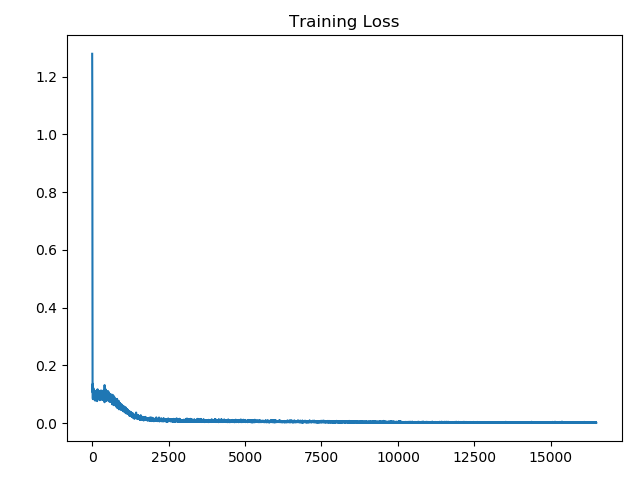

In [6]:
%matplotlib notebook

import sys, os
sys.path.append("/home/daniil/repos/pytorch-segmentation-detection/")
sys.path.insert(0, '/home/daniil/repos/pytorch-segmentation-detection/vision/')

from matplotlib import pyplot as plt

# importing a list that can be binded with a figure and update
# the figure when being appended
from pytorch_segmentation_detection.utils.visualization import VizList

# Creating figure, axes and binding to lists 
f, (loss_axis) = plt.subplots(1, 1)

loss_axis.plot([], [])

loss_list = VizList()

loss_list.bind_to_axis(loss_axis)

loss_axis.set_title('Training Loss')

plt.tight_layout()

In [ ]:
truncated_seq_length = 5000
epochs_number = 100000000

# Needed for truncated back prop
# Credit https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/language_model/main.py
def detach(states):
    return [state.detach() for state in states] 


for epoch_number in xrange(epochs_number):

    for batch in trainset_loader:
        
        post_processed_batch_tuple = post_process_sequence_batch(batch)
        input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

        hidden = None

        # Truncated back prop for the current batch
        for i in xrange(0, input_sequences_batch.size(0), truncated_seq_length):

            truncated_inputs = input_sequences_batch[i:i+truncated_seq_length, : ,:]
            truncated_outputs = output_sequences_batch[:, i:i+truncated_seq_length, :]

            truncated_outputs_var = Variable( truncated_outputs.contiguous().view(-1).cuda() )
            truncated_inputs_var = Variable( truncated_inputs.cuda() )

            optimizer.zero_grad()

            logits, hidden = rnn(truncated_inputs_var, hidden)
            hidden = detach(hidden)

            loss = criterion(logits, truncated_outputs_var)

            loss.backward()
            optimizer.step()

            loss_list.append( loss.data[0] )
    
    torch.save(rnn.state_dict(), 'music_rnn_truncated.pth')

Process Process-5507:
    self._target(*self._args, **self._kwargs)
Process Process-5505:
Process Process-5508:
Process Process-5506:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/daniil/repos/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/daniil/repos/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/daniil/repos/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/home/daniil/repos/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self.run()
  File "/home/daniil/repos/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/daniil/repos/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/daniil/repos/anaconda2/lib/python2.7/multiprocessing/proc

KeyboardInterrupt: 